### Requirements and Dimensions
The motors will be mounted with 2.5 x 1 cm mirrors. The centre of mass of the mirrors will be at the axis of rotation of the motors. 

The mirrors will be salvaged from the platter of a broken hard drive. These platters are between 1.25 and 0.25 mm thick and are made out of aluminium or glass, which both have a density of around $2.7\,g/cm^3$. A platter thickness of 1.25mm = 0.123cm was used as a conservative measure.

In [1]:
import math
import numpy as np

# REQUIREMENTS
SPEED = 1  # m/s # The top speed of the stepper motor.
TIME = 0.001  # s (1ms) # The time in which the stepper motor must come to a stop from top speed.
REQUIRED_RESOLUTION = 0.1 # mm # The resolution of the stepper motor when translated to linear motion.

# Mirror dimensions
WIDTH = 0.01 # m (1cm)
HEIGHT = 0.025 # m (2.5cm)
THICKNESS = 0.00125 # m (1.25mm)
DENSITY = 2700 # kg/m^3 (2.7g/cm^3)

### Moment of Inertia

The mirrors will be rotating around its centre and will be approximated as cylinders. 

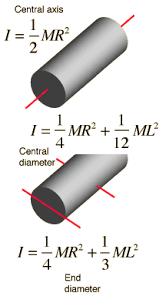

Therefore the equation for the moment of inertia is

$
I = \frac{1}{2}MR^2
$

where 

- $R$ is the radius of the axis of rotation
- $M$ is the mass of the cylinder

In [2]:
volume = math.pi * (WIDTH / 2)**2 * HEIGHT # Volume of a cylinder = πr^2h
mass = DENSITY * volume # kg

# Moment of inertia of a cylinder = 1/2 * m * r^2
radius = WIDTH / 2
moment_of_inertia = 0.5 * mass * radius**2
print(f'Moment of inertia: {moment_of_inertia:.15f} kg*m^2')

Moment of inertia: 0.000000066267970 kg*m^2


### Angular acceleration
$\alpha = \frac{\Delta \omega}{\Delta t}$

According to Google, the speed of a mosquito is 1.6 - 2.4 km/h. 2.4 km/h = 0.67 m/s. The laser turret should be able to move at least twice as fast as a mosquito and change direction very rapidly. To conservative the speed at which the laser turret must be able to move will be chosen as ***5 m/s***.

The preliminary design for the turret system is such that $40\degree$ of rotation translates to 1m of lateral movement. Thus to achieve a speed of 5m/s, the motor will have to rotate $40\degree$ in 0.2s.

$1\,m/s = 40\degree /s \implies x\,m/s = x \times 40\degree /s$

In [3]:
# Angular acceleration
degrees_per_second = 40 * SPEED  
rad_per_second = degrees_per_second * math.pi / 180
angular_acceleration = rad_per_second / TIME # rad/s^2
print(f'Angular acceleration: {angular_acceleration:.3f} rad/s^2')

Angular acceleration: 698.132 rad/s^2


### Torque and Speed

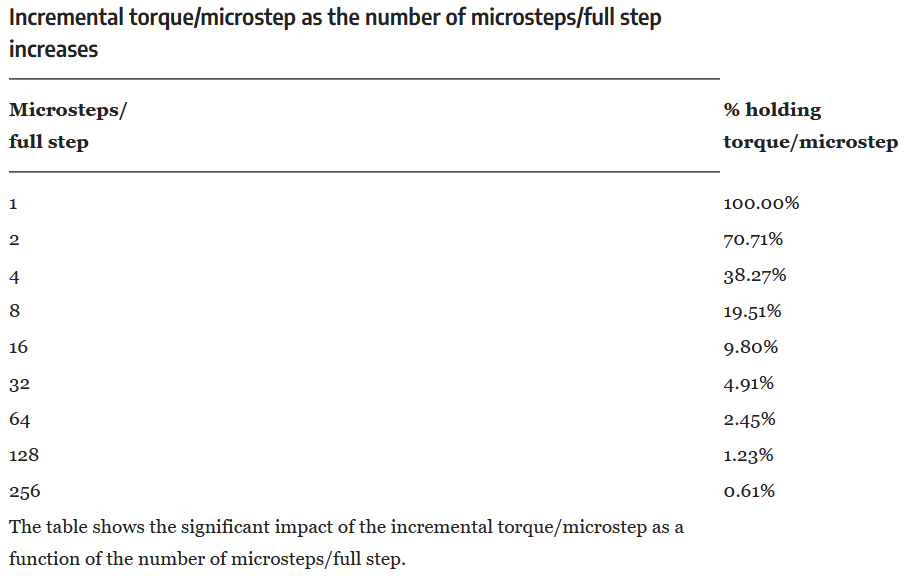

<!-- <div>
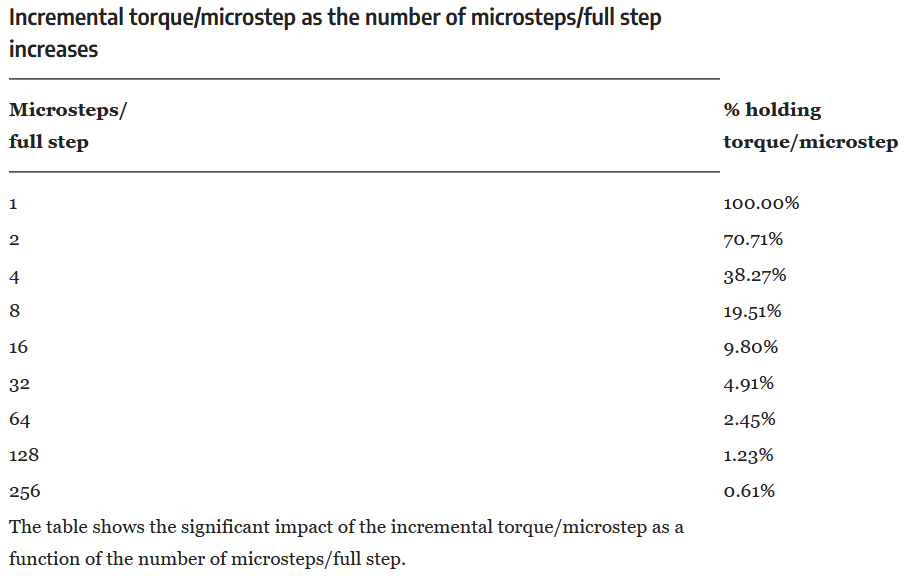
</div> -->

256 mircosteps will be requierd.

$\tau = I\alpha$

In [4]:
import pandas as pd
from prettytable import PrettyTable

FULLSTEP_ANGLE = 0.29  # degrees
MICRO_STEPS = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256])
TORQUE_REDUCTION = np.array([100.0, 70.71, 38.27, 19.51, 9.8, 4.91, 2.45, 1.23, 0.61]) # %

print(f"Lateral Speed: {SPEED} m/s")
# Degrees per second
# print(f"Degrees per second: {degrees_per_second:.2f}")
# Degrees per second to RPM
rpm = degrees_per_second / 360 * 60
print(f"RPM: {rpm:.2f}")
# Fullsteps per second
fullsteps_per_second = degrees_per_second / FULLSTEP_ANGLE
# Microsteps per second
microsteps_per_second = fullsteps_per_second * MICRO_STEPS

# Lateral step distance
lat_step_size = 1400 * np.tan((FULLSTEP_ANGLE * np.pi / 180) / MICRO_STEPS) # mm

# Torque
torque = moment_of_inertia * angular_acceleration
# Micro-stepping torque reduction
req_torque = [torque * (100 / x) for x in TORQUE_REDUCTION]

# Create a new table
table = PrettyTable()
table.field_names = ['Microsteps', 'Required torque (Nm)', 'Lateral step size (mm)', 'Steps per second']
# Set the alignment of all columns to 'r' (right)
table.align = 'r'

# Add rows to the table
for reduction, torque, step_size, steps_pre_sec in zip(MICRO_STEPS, req_torque, lat_step_size, microsteps_per_second):
    table.add_row([reduction, round(torque, 6), round(step_size, 2), round(steps_pre_sec, 2)])

# Display the table
print(table)



# Add redution gears to the stepper motor
for mic_steps in MICRO_STEPS:
    print(f"\n{mic_steps} MICROSTEPS")
    index = np.where(MICRO_STEPS == mic_steps)[0][0]
    reduction_gears = np.arange(1, 11)

    required_torque = [req_torque[index] / x for x in reduction_gears]
    lateral_step_size = [lat_step_size[index] / x for x in reduction_gears]
    required_speed = [microsteps_per_second[index] * x for x in reduction_gears]
    required_rpm = [rpm * x for x in reduction_gears]

    table = PrettyTable()
    table.field_names = ['Reduction', 'Required torque (Nm)', 'Lateral step (mm)', 'Steps per second', 'RPM']
    table.align = 'r'
    for reduction, torque, step_size, steps_pre_sec, rpm1 in zip(reduction_gears, required_torque, lateral_step_size, required_speed, required_rpm):
        table.add_row([reduction, round(torque, 6), round(step_size, 2), round(steps_pre_sec, 2), round(rpm1, 2)])

    # Display the table
    print(table)




# Print out constant variables
print("\n----------------- Constant variables -----------------")
constant_variables = [var_name for var_name, var_value in globals().items()
                      if var_name.isupper() and not callable(var_value)]
for var_name in constant_variables:
    print(f"{var_name}: {globals()[var_name]}")

Lateral Speed: 1 m/s
RPM: 6.67
+------------+----------------------+------------------------+------------------+
| Microsteps | Required torque (Nm) | Lateral step size (mm) | Steps per second |
+------------+----------------------+------------------------+------------------+
|          1 |              4.6e-05 |                   7.09 |           137.93 |
|          2 |              6.5e-05 |                   3.54 |           275.86 |
|          4 |             0.000121 |                   1.77 |           551.72 |
|          8 |             0.000237 |                   0.89 |          1103.45 |
|         16 |             0.000472 |                   0.44 |           2206.9 |
|         32 |             0.000942 |                   0.22 |          4413.79 |
|         64 |             0.001888 |                   0.11 |          8827.59 |
|        128 |             0.003761 |                   0.06 |         17655.17 |
|        256 |             0.007584 |                   0.03 |     